In [1]:
import os
from tqdm import tqdm
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely

from enum import Enum

from FrontierExploration.preprocessing.layout.polygons import Square
from FrontierExploration.preprocessing.grid.visibility_grid import VisibilityGrid

base_dir = os.getcwd()
files_dir = f"{base_dir}/files"
file_dir = f"{files_dir}/small_house_clean.dxf"


In [2]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString, MultiPolygon

UNKNOWN = -1
OCCUPIED = 100
SEEN = 50

class BlockStatus(Enum):
    Seen = SEEN
    Occupied = OCCUPIED
    Unknown = UNKNOWN
    Raycasted = 125

class RayCast:
    def __init__(self, num_rays: int, ray_range: float, start_x: float = 0, start_y: float = 0):
        self.start_x = start_x
        self.start_y = start_y
        self._num_rays = num_rays
        self._ray_range = ray_range
        self.raycast_df = gpd.GeoDataFrame(geometry=[LineString([(start_x, start_y), movement]) for movement in self.directions])
        self.raycast_df["status"] = BlockStatus.Raycasted.value

    def run_on_df(self, layout_df: gpd.GeoDataFrame):
        for index in tqdm(layout_df[layout_df["status"] == BlockStatus.Occupied.value].index):
            self.intersect_with_polygon(layout_df['geometry'][index],layout_df['status'][index])

        for index in tqdm(layout_df[layout_df["status"] == BlockStatus.Seen.value].index):
            self.intersect_with_polygon(layout_df['geometry'][index], BlockStatus.Seen.value)
        
            
    def intersect_with_polygon(self, polygon: Polygon, block_status: BlockStatus):
        if block_status == BlockStatus.Occupied.value:
            self.raycast_df["geometry"] = self.raycast_df["geometry"].apply(self.get_line_to_intersection, args=(polygon,))
        if block_status == BlockStatus.Seen.value:
            poly_df = gpd.GeoDataFrame(geometry=[polygon])
            self.raycast_df["geometry"] = self.raycast_df.overlay(poly_df, how='difference')["geometry"]
            self.raycast_df.dropna(inplace=True)
    
    def get_line_to_intersection(self, line: LineString, polygon: Polygon):
        origin = self.origin_point
        if line.intersects(polygon):
            inter_line = line.difference(polygon)
            if isinstance(inter_line, MultiLineString):
                return inter_line[0]
            return inter_line
        return line        

    @property
    def visibility_percentage(self):
        return 100*self.visibility/self._ray_range
    
    @property
    def visibility(self):
        self.raycast_df.dropna(inplace=True)
        self.raycast_df['length'] = self.raycast_df.apply(lambda row: row[0].length, axis=1)
        return self.raycast_df['length'].mean()
    
    @property
    def origin_point(self):
        return Point(self.start_x, self.start_y)
    
    @property
    def directions(self):
        return [(self._ray_range*np.cos(angle)+self.start_x, self._ray_range*np.sin(angle)+self.start_y) for angle in np.linspace(0, 2 * np.pi, num=self._num_rays, endpoint=False)]

    def plot(self, *args, **kwargs):
        self.raycast_df.plot( *args, **kwargs)

  0%|                                                                                                                                                              | 0/1 [00:00<?, ?it/s]/home/agusmazzeo/Documents/UTN/Proyecto/Frontier-Exploration-with-a-prior/src/FrontierExploration/preprocessing/grid/raycasting.py:106: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return inter_line[0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.09it/s]
0it [00:00, ?it/s]


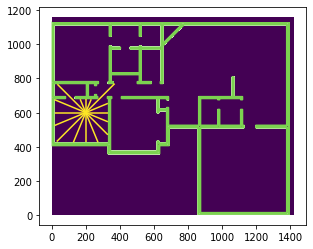

In [8]:
layout = gpd.read_file(file_dir)
bounds = layout.unary_union.bounds
tf_to_zero = [1, 0, 0, 1, -bounds[0], -bounds[1]]
layout = layout["geometry"].apply(lambda x: shapely.affinity.affine_transform(x, tf_to_zero)).unary_union.buffer(0.3)
visibility_grid = VisibilityGrid(layout=layout, square_size=0.05)
# raycast = RayCast(num_rays=50, ray_range=200, start_x=200, start_y=600)
# raycast.run_on_df(visibility_grid._occupancy_df)
# raycast.raycast_df.append(visibility_grid._occupancy_df).plot(column="status", figsize=(15, 10))
visibility_grid.visibility(10, 30)
visibility_grid.plot()